<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/varseqlen/LMP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install package dependencies (forces restart)
import os

def restart_runtime():
    print('Runtime restarting...')
    os.kill(os.getpid(), 9)

%pip -q install pybullet wandb
!git clone https://github.com/sholtodouglas/pandaRL local_packages/pandaRL
%pip install -e local_packages/pandaRL/.

restart_runtime()

     |████████████████████████████████| 102.0MB 42kB/s 
Cloning into 'local_packages/pandaRL'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 290 (delta 144), reused 230 (delta 88), pack-reused 0
Receiving objects: 100% (290/290), 3.10 MiB | 15.66 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Obtaining file:///content/local_packages/pandaRL
  Running setup.py develop for pandaRL


In [56]:
#@title Workpace Setup (Local vs Colab)
from google.colab import drive, auth
from os.path import join
import os

COLAB = True #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
DEVICE = "TPU" #@param ["TPU", "GPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
DATASET = "one_obj_play" #@param ["play_data", "one_obj_play"]
GCS_USER = "tristan" #@param ["sholto", "tristan"]
if COLAB:
    if AUTH_GCS:
        auth.authenticate_user()
        if GCS_USER == 'tristan':
          GCS_PROJECT = "learning-from-play"
          GCS_BUCKET = "colab-gcs"
        else:
          GCS_PROJECT = "learning-from-play-288601"
          GCS_BUCKET = "colab-gcs1"

        !gcloud config set project {GCS_PROJECT}
    if DATA_SOURCE == "GCS":
        ROOT = 'gs://colab-gcs'
        PROJ = 'data/one_obj_play'
        PROJECT_PATH = '/content/data'
        !mkdir /content/data
        !gsutil -m cp -r {ROOT}/{PROJ} {PROJECT_PATH}
    else:
        ROOT = '/content/drive'     # default for the drive
        PROJ = 'My Drive/Robotic Learning'       # path to your project on Drive
        PROJECT_PATH = os.path.join(ROOT, PROJ)
        drive.mount(ROOT)           # we mount the drive at /content/drive
    PYBULLET_DATA_DIR = os.path.join(PROJECT_PATH, DATASET)

    # Sync drive to VM directory
    # !rsync -aP --exclude=data/ "{PROJECT_PATH}/"  '/content/learning_from_play'
    # %cd '/content/learning_from_play'
else:
    # Todo:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/sholtodouglas/learning_from_play
%pip install wandb -q

Cloning into 'learning_from_play'...
remote: Enumerating objects: 642, done.
remote: Total 642 (delta 0), reused 0 (delta 0), pack-reused 642
Receiving objects: 100% (642/642), 26.09 MiB | 35.24 MiB/s, done.
Resolving deltas: 100% (245/245), done.


In [57]:
%cd '/content/learning_from_play'

/content/learning_from_play


In [ ]:
!git status

UsageError: Line magic function `%git` not found.


In [ ]:
!git add .

In [ ]:
!git pull

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/sholtodouglas/learning_from_play
   fe67aab..e63475a  master     -> origin/master
hint: Waiting for your editor to close the file... error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [ ]:
!git clone git@github.com:sholtodouglas/learning_from_play.git

Cloning into 'learning_from_play'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
#@title Git config (for commits)
email = "tfrizza@gmail.com" #@param {type:"string"}
name = "tfrizza" #@param {type:"string"}

!git config --global user.email "{email}"
!git config --global user.name "{name}"

In [ ]:
#@title Git commit
commit_msg = "Beta scheduler updates" #@param {type:"string"}
!git commit -m "{commit_msg}"

[master 4cdfc2d] Beta scheduler updates


In [ ]:
#@title Git push
branch = "master" #@param ["master"] {allow-input: true}
!git push -u origin {branch}

fatal: could not read Username for 'https://github.com': No such device or address


# Data Creation

In [58]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.3.0
Running on TPU  ['10.32.28.194:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.32.28.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.28.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

In [59]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import data

In [ ]:
# Use this to edit modules without needing to restart the kernel
# import importlib
# importlib.reload(data)

In [60]:
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses']
physical_devices = tf.config.list_physical_devices()
if DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


In [61]:
RELATIVE_JOINTS = True # use relative joints instead of absolute pos/ori as in the orgininal paper

In [62]:
def load_data(path, keys):
    dataset = {k:[] for k in keys+['sequence_index','sequence_id']}
    obs_act_path = os.path.join(path, 'obs_act_etc/')

    for demo in os.listdir(obs_act_path):
        traj = np.load(obs_act_path+demo+'/data.npz')
        for k in keys:
            dataset[k].append(traj[k].astype(np.float32))
        timesteps = len(traj['obs'])
        dataset['sequence_index'].append(np.arange(timesteps, dtype=np.int32).reshape(-1, 1))
        dataset['sequence_id'].append(np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1))

    # convert to numpy
    for k in keys+['sequence_index','sequence_id']:
        dataset[k] = np.vstack(dataset[k])
    return dataset

In [63]:
dataset = load_data(PYBULLET_DATA_DIR, keys)

if RELATIVE_JOINTS:
    OBS_DIM = dataset['obs'].shape[1] + 7
    ACT_DIM = dataset['target_poses'].shape[1] + 1
else:
    OBS_DIM = dataset['obs'].shape[1]
    ACT_DIM = dataset['acts'].shape[1]
GOAL_DIM = dataset['achieved_goals'].shape[1]
print(f'Obs: (N,{OBS_DIM}), Acts: (N,{ACT_DIM}), Goals: (N,{GOAL_DIM})')

Obs: (N,26), Acts: (N,8), Goals: (N,11)


In [64]:
DATASET_SIZE = dataset['obs'].shape[0]
secs = DATASET_SIZE / 20
hours = secs // 3600
minutes = secs // 60 - hours * 60
print(f"We have {DATASET_SIZE} frames of data, which is {hours:.0f}hrs {minutes:.0f}m.")

We have 104802 frames of data, which is 1hrs 27m.


In [156]:
BATCH_SIZE_PER_REPLICA = 512
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

WINDOW_SIZE = 40
MIN_WINDOW_SIZE = WINDOW_SIZE//2
WINDOW_SHIFT = 1
SHUFFLE_SIZE = GLOBAL_BATCH_SIZE*4
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
NUM_WORKERS = 4
TRAIN_TEST_SPLIT = 0.9
VARIABLE_SEQ_LENS = True

window_lambda = lambda x: tf.data.Dataset.zip(x).batch(WINDOW_SIZE)
seq_overlap_filter = lambda x: tf.equal(tf.size(tf.unique(tf.squeeze(x['sequence_id'])).y), 1)

def create_goal_tensor(dataset, seq_len=-1):
    ''' Tile final achieved_goal across time dimension '''
    tile_dims = tf.constant([WINDOW_SIZE, 1], tf.int32)
    goal = tf.tile(dataset['achieved_goals'][seq_len-1,tf.newaxis], tile_dims) # as goal is at an index take seq_len -1
    return goal

def transform_states(dataset):
    if RELATIVE_JOINTS:
        rel = dataset['target_poses'] - dataset['joint_poses'][:,:7]
        gripper = dataset['acts'][:,-1,tf.newaxis]
        acts = tf.concat([rel, gripper], axis=-1)
        obs = tf.concat([dataset['obs'],dataset['joint_poses'][:,:7]], axis=-1)#.astype('float32')
    else:
        acts = dataset['acts']
        obs = dataset['obs']
    
    
    # Variable Seq len
    if VARIABLE_SEQ_LENS:
      seq_len = tf.random.uniform(shape=[], minval=MIN_WINDOW_SIZE, maxval=WINDOW_SIZE, dtype=tf.int32, seed=10)
    else:
      seq_len = WINDOW_SIZE # SEQLENS Just at max window size

    mask = tf.cast(tf.sequence_mask(seq_len, maxlen=WINDOW_SIZE), tf.float32) # creates a B*T mask
    multiply_mask = tf.expand_dims(mask, -1)

    goals = create_goal_tensor(dataset, seq_len)

    obs = obs * multiply_mask
    acts = acts * multiply_mask
    goals = goals * multiply_mask

    return {'obs':obs, 'acts':acts, 'goals':goals, 'seq_lens': tf.cast(seq_len, tf.float32), 'masks':mask}

def tf_ds_transform(dataset):
    return dataset\
                .window(size=WINDOW_SIZE, shift=WINDOW_SHIFT, stride=1, drop_remainder=True)\
                .flat_map(window_lambda)\
                .filter(seq_overlap_filter)\
                .shuffle(SHUFFLE_SIZE)\
                .repeat()\
                .map(transform_states, num_parallel_calls=NUM_WORKERS)\
                .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)\
                .prefetch(PREFETCH_SIZE)\
                # .cache()

# Todo: Need to confirm splitting here works with shuffle() and repeat()
train_size = int(TRAIN_TEST_SPLIT * DATASET_SIZE)

full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = tf_ds_transform(full_dataset.take(train_size))
valid_dataset = tf_ds_transform(full_dataset.skip(train_size))
train_dataset

<PrefetchDataset shapes: {obs: (4096, 40, 26), acts: (4096, 40, 8), goals: (4096, 40, 11), seq_lens: (4096,), masks: (4096, 40)}, types: {obs: tf.float32, acts: tf.float32, goals: tf.float32, seq_lens: tf.float32, masks: tf.float32}>

# Model

In [157]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

## LSTM Model
Use this to map obs -> act

In [158]:
def create_actor(layer_size=1024, training=True, latent_dim = 128, GCBC=False):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    if GCBC:
      x = Concatenate()([o,g])
    else:
      x =  Concatenate()([o,z,g])

    x = Masking(mask_value=0.)(x)
    x = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful, name='LSTM_in_1')(x)
    x = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful, name='LSTM_in_2')(x)
    acts = Dense(ACT_DIM-1, activation=None, name='acts')(x)
    gripper = Dense(1, activation='sigmoid', name='gripper')(x)*0.04

    actions = Concatenate()([acts, gripper])

    if GCBC:
      return Model([o, g], actions)
    else:
      return Model([o, z, g], actions)

model_params = {'layer_size':1024, 'latent_dim':False}
model = create_actor(**model_params)

In [159]:
from tensorflow.keras.layers import Bidirectional

def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist

class encoder_lstm(Model):
  def __init__(self, layer_size=1024, latent_dim=256, p_dropout=0.3):
    super(encoder_lstm, self).__init__()

    self.bi_lstm = Bidirectional(LSTM(layer_size, return_sequences=True, return_state=False), merge_mode='concat')
    self.bi_lstm2 = Bidirectional(LSTM(layer_size, return_sequences=True, return_state=False), merge_mode=None)
    self.mu = Dense(latent_dim)
    self.scale = Dense(latent_dim, activation='softplus')
    self.dropout1 = tf.keras.layers.Dropout(p_dropout)
    self.dropout2 = tf.keras.layers.Dropout(p_dropout)

  def call(self, obs, acts, training = False):
    x = tf.concat([obs,acts], axis = 2) # concat observations and actions together.
    x = self.bi_lstm(x)
    x = self.dropout1(x, training=training)
    x = self.bi_lstm2(x)
    bottom = x[0][:,-1, :] # Take the last element of the bottom row
    top = x[1][:,0,:] # Take the first elemetn of the top row cause Bidirectional, top row goes backward.
    x = tf.concat([bottom, top], axis = 1)
    x = self.dropout2(x, training=training)
    mu = self.mu(x)
    s = self.scale(x)
    dist = tfd.Normal(loc=mu, scale=s)
    return dist


def create_planner(layer_size=2048, training=True, epsilon=1e-4, latent_dim = 256):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    o_g = Input(shape=(GOAL_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate()([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    x = Dense(layer_size, activation="relu", name='layer_4')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)

    
    mixture = tfpl.DistributionLambda(latent_normal,  name='latent_variable')((mu, scale))
    return Model([o_i, o_g], [mixture,mu])

# Training Loop

In [160]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa

import time
import io
import wandb
wandb.login()
#%load_ext tensorboard

True

In [161]:
# Explore regularising the encoder using info-VAE, while concurrently making the planner chase it
# Add latent space projection plots

In [178]:
LAYER_SIZE = 1024
LATENT_DIM = LAYER_SIZE//8

GRIPPER_WEIGHT = 5.0

with strategy.scope():
  #loss_fn = lambda y, p_y: -p_y.log_prob(y)
  #action_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.NONE)
  action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

  def compute_loss(labels, predictions, mask, seq_lens):
      # Scale gripper loss
      action_weights = (ACT_DIM-1)*[1.0] + [GRIPPER_WEIGHT] # 1 for all but gripper
      labels = tf.multiply(labels, action_weights)
      predictions = tf.multiply(predictions, action_weights)

      per_example_loss = action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_regularisation_loss(plan, encoding):
      # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
      reg_loss = tfd.kl_divergence(encoding, plan) #+ KL(plan, encoding)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  valid_loss = tf.keras.metrics.Mean(name='valid_loss')

  train_act_with_enc_loss = tf.keras.metrics.Mean(name='train_act_with_enc_loss')
  train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')
  valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
  valid_act_with_plan_loss = tf.keras.metrics.Mean(name='valid_act_with_plan_loss')

  train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
  valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')
  
  model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
  model = create_actor(**model_params)

  model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
  encoder = encoder_lstm(latent_dim=LATENT_DIM)
  planner = create_planner(**model_params)

  optimizer = tfa.optimizers.AdamW(weight_decay=1e-4, learning_rate=2e-4)
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

# Now outside strategy .scope
def train_step(inputs, beta, GCBC=False):
  with tf.GradientTape() as tape:
    # Todo: figure out mask and seq_lens for new dataset 
    states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']
    if GCBC:
      distrib = model([states, goals])
      act_loss = compute_loss(actions, distrib, mask, seq_lens)
    else:
      encoding = encoder(states, actions, training=True)
      plan, _ = planner((states[:, 0, :], goals[:, 0, :]))  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 

      z_enc = encoding.sample()
      z_plan = plan.sample()
      z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, WINDOW_SIZE, 1))
      z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, WINDOW_SIZE, 1))
      enc_acts = model([states, z_enc_tiled, goals])
      plan_acts = model([states, z_plan_tiled, goals])

      act_enc_loss = compute_loss(actions, enc_acts, mask, seq_lens)
      act_plan_loss = compute_loss(actions, plan_acts, mask, seq_lens)
      act_loss = act_enc_loss
      reg_loss = compute_regularisation_loss(plan, encoding)
      train_act_with_enc_loss.update_state(act_enc_loss)
      train_act_with_plan_loss.update_state(act_plan_loss)
      train_reg_loss.update_state(reg_loss)
    
    loss = act_loss + reg_loss * beta  
  train_loss.update_state(loss)

  gradients = tape.gradient(loss, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables))
  return loss

def test_step(inputs, beta, GCBC=False):
  states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']
  if GCBC:
    distrib = model([states, goals])
    act_loss = compute_loss(actions, distrib, mask, seq_lens)
  else:
    encoding = encoder(states, actions, training=False)
    plan, _ = planner((states[:, 0, :], goals[:, 0, :]))  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 

    z_enc = encoding.sample()
    z_plan = plan.sample()
    z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, WINDOW_SIZE, 1))
    z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, WINDOW_SIZE, 1))
    enc_acts = model([states, z_enc_tiled, goals])
    plan_acts = model([states, z_plan_tiled, goals])

    act_enc_loss = compute_loss(actions, enc_acts, mask, seq_lens)
    act_plan_loss = compute_loss(actions, plan_acts, mask, seq_lens)
    act_loss = act_plan_loss
    reg_loss = compute_regularisation_loss(plan, encoding)
    valid_act_with_enc_loss.update_state(act_enc_loss)
    valid_act_with_plan_loss.update_state(act_plan_loss)
    valid_reg_loss.update_state(reg_loss)

  loss = act_loss + reg_loss * beta
  valid_loss.update_state(loss)
  return loss, z_enc, z_plan

@tf.function
def distributed_train_step(dataset_inputs, beta):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs, beta))
  return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

@tf.function
def distributed_test_step(dataset_inputs, beta):
  per_replica_losses, ze, zp = strategy.run(test_step, args=(dataset_inputs, beta))
  # Todo: decide on z averaging strategy
  return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]


train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

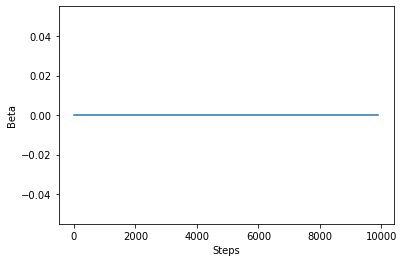

In [168]:
from train import BetaScheduler
beta_sched = BetaScheduler('constant', 
                           beta=0, 
                           beta_max=0.001, 
                           max_steps=n_steps, 
                           cycles=5, 
                           duty_cycle=0.5
                           )

In [169]:
import umap
reducer = umap.UMAP(metric='cosine', random_state=42)

def project_latents(reducer, z_enc, z_plan):
    ''' Todo: may need to rethink vector averaging here... '''
    reducer.fit(z_enc)
    z_enc_embed = reducer.transform(z_enc)
    z_plan_embed = reducer.transform(z_plan)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(z_enc_embed[:, 0], z_enc_embed[:, 1], s=5, label='z_enc')
    ax.scatter(z_plan_embed[:, 0], z_plan_embed[:, 1], s=5, label='z_plan')
    ax.set_aspect('equal', 'datalim')
    ax.legend(loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    return fig

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [179]:
n_steps = 10000
progbar = Progbar(n_steps, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
t = 0

USE_TB = False

if USE_TB:
    # Init tensorboard
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tb_base_dir = f'gs://{GCS_BUCKET}/tensorboard_logs'
    # tb_base_dir = os.path.join(PROJECT_PATH, 'tb_logs')
    tb_base_dir = os.path.join(os.getcwd(), 'tb_logs')
    train_log_dir = tb_base_dir + '/gradient_tape/' + current_time + '/train'
    test_log_dir = tb_base_dir + '/gradient_tape/' + current_time + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)
    print(f'Logging run to: {train_log_dir}')
else:
    print('Not using Tensorboard, logging locally.')


train_loss_result = []
train_act_with_enc_loss_result = []
train_act_with_plan_loss_result = []
train_reg_loss_result = []
valid_loss_result = []
valid_act_with_enc_loss_result = []
valid_act_with_plan_loss_result = []
valid_reg_loss_result = []
beta_result = []
latent_img_result = []

# WandB
wandb.init(project="learning-from-play")
config = wandb.config

# Hparams
config.DEVICE = DEVICE
config.BATCH_SIZE_PER_REPLICA = BATCH_SIZE_PER_REPLICA
config.WINDOW_SIZE = WINDOW_SIZE
config.WINDOW_SHIFT = WINDOW_SHIFT
config.SHUFFLE_SIZE = SHUFFLE_SIZE
config.PREFETCH_SIZE = PREFETCH_SIZE
config.NUM_WORKERS = NUM_WORKERS
config.TRAIN_TEST_SPLIT = TRAIN_TEST_SPLIT
config.LAYER_SIZE = LAYER_SIZE
config.LATENT_DIM = LATENT_DIM
config.GRIPPER_WEIGHT = GRIPPER_WEIGHT
#config.beta_schedule = beta_sched.schedule
config.beta_min = beta_sched.beta_min
config.beta_max = beta_sched.beta_max
config.n_steps = n_steps

Not using Tensorboard, logging locally.


In [ ]:
while t < n_steps:
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = distributed_train_step(x, beta)
    
    if t % valid_inc == 0:
        
        valid_x = next(valid_dist_dataset)
        total_val_loss, ze, zp = distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', train_loss.result()), ('Validation Loss', valid_loss.result())])

        # Latent space projection
        latent_fig = project_latents(reducer, ze, zp)
        latent_img = plot_to_image(latent_fig)

        train_loss_result.append(train_loss.result())
        train_act_with_enc_loss_result.append(train_act_with_enc_loss.result())
        train_act_with_plan_loss_result.append(train_act_with_plan_loss.result())
        train_reg_loss_result.append(train_reg_loss.result())
        valid_loss_result.append(valid_loss.result())
        valid_act_with_enc_loss_result.append(valid_act_with_enc_loss.result())
        valid_act_with_plan_loss_result.append(valid_act_with_plan_loss.result())
        valid_reg_loss_result.append(valid_reg_loss.result())

        beta_result.append(beta)
        latent_img_result.append(latent_img)

        wandb.log({'train_loss_result':train_loss_result[-1],
                    'train_act_with_enc_loss_result':train_act_with_enc_loss_result[-1],
                    'train_act_with_plan_loss_result':train_act_with_plan_loss_result[-1],
                    'train_reg_loss_result':train_reg_loss_result[-1],
                    'valid_loss_result':valid_loss_result[-1],
                    'valid_act_with_enc_loss_result':valid_act_with_enc_loss_result[-1],
                    'valid_act_with_plan_loss_result':valid_act_with_plan_loss_result[-1],
                    'valid_reg_loss_result':valid_reg_loss_result[-1],
                    'beta_result':beta_result[-1],
                    'latent_img_result':latent_fig,
                   },
                  step=t)

        # # TB logging
        if USE_TB:
            with train_summary_writer.as_default():
                tf.summary.scalar('losses/loss', train_loss_result[-1], step=t)
                tf.summary.scalar('losses/act_with_enc_loss', train_act_with_enc_loss_result[-1], step=t)
                tf.summary.scalar('losses/act_with_plan_loss', train_act_with_plan_loss_result[-1], step=t)
                tf.summary.scalar('losses/reg_loss', train_reg_loss_result[-1], step=t)
                tf.summary.scalar('hparams/beta', beta, step=t)

            with test_summary_writer.as_default():
                tf.summary.scalar('losses/loss', valid_loss_result[-1], step=t)
                tf.summary.scalar('losses/act_with_enc_loss', valid_act_with_enc_loss_result[-1], step=t)
                tf.summary.scalar('losses/act_with_plan_loss', valid_act_with_plan_loss_result[-1], step=t)
                tf.summary.scalar('losses/reg_loss', valid_reg_loss_result[-1], step=t)
                if t % (5*valid_inc) == 0:
                    tf.summary.image("Latent space projection", latent_img, step=t)
        
        # reset metrics
        train_loss.reset_states()
        train_act_with_enc_loss.reset_states()
        train_act_with_plan_loss.reset_states()
        train_reg_loss.reset_states()
        valid_loss.reset_states()
        valid_act_with_enc_loss.reset_states()
        valid_act_with_plan_loss.reset_states()
        valid_reg_loss.reset_states()

    t += 1

   40/10000 [..............................] - ETA: 4:57:37 - Train Loss: 0.0104 - Validation Loss: 0.0113

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



   60/10000 [..............................] - ETA: 4:11:53 - Train Loss: 0.0089 - Validation Loss: 0.0092

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



   80/10000 [..............................] - ETA: 3:49:18 - Train Loss: 0.0081 - Validation Loss: 0.0082

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  100/10000 [..............................] - ETA: 3:35:36 - Train Loss: 0.0075 - Validation Loss: 0.0076

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  120/10000 [..............................] - ETA: 3:28:16 - Train Loss: 0.0072 - Validation Loss: 0.0073

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  140/10000 [..............................] - ETA: 3:21:58 - Train Loss: 0.0069 - Validation Loss: 0.0070

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  160/10000 [..............................] - ETA: 3:16:12 - Train Loss: 0.0067 - Validation Loss: 0.0069

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  180/10000 [..............................] - ETA: 3:12:41 - Train Loss: 0.0065 - Validation Loss: 0.0068

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  200/10000 [..............................] - ETA: 3:10:00 - Train Loss: 0.0063 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  220/10000 [..............................] - ETA: 3:07:28 - Train Loss: 0.0062 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  240/10000 [..............................] - ETA: 3:05:56 - Train Loss: 0.0061 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  260/10000 [..............................] - ETA: 3:04:46 - Train Loss: 0.0059 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  280/10000 [..............................] - ETA: 3:03:48 - Train Loss: 0.0058 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  300/10000 [..............................] - ETA: 3:02:08 - Train Loss: 0.0058 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  320/10000 [..............................] - ETA: 3:00:19 - Train Loss: 0.0057 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  340/10000 [>.............................] - ETA: 2:59:02 - Train Loss: 0.0056 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  360/10000 [>.............................] - ETA: 2:57:54 - Train Loss: 0.0055 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  380/10000 [>.............................] - ETA: 2:56:38 - Train Loss: 0.0055 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  400/10000 [>.............................] - ETA: 2:55:25 - Train Loss: 0.0054 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  420/10000 [>.............................] - ETA: 2:55:03 - Train Loss: 0.0053 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  440/10000 [>.............................] - ETA: 2:54:30 - Train Loss: 0.0053 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  460/10000 [>.............................] - ETA: 2:54:04 - Train Loss: 0.0052 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  480/10000 [>.............................] - ETA: 2:53:17 - Train Loss: 0.0052 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  500/10000 [>.............................] - ETA: 2:52:06 - Train Loss: 0.0051 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  520/10000 [>.............................] - ETA: 2:51:37 - Train Loss: 0.0050 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  540/10000 [>.............................] - ETA: 2:51:01 - Train Loss: 0.0050 - Validation Loss: 0.0066

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  560/10000 [>.............................] - ETA: 2:50:27 - Train Loss: 0.0049 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  580/10000 [>.............................] - ETA: 2:49:45 - Train Loss: 0.0049 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  600/10000 [>.............................] - ETA: 2:49:12 - Train Loss: 0.0048 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  620/10000 [>.............................] - ETA: 2:48:28 - Train Loss: 0.0047 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  640/10000 [>.............................] - ETA: 2:47:44 - Train Loss: 0.0047 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  660/10000 [>.............................] - ETA: 2:47:00 - Train Loss: 0.0046 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  680/10000 [=>............................] - ETA: 2:46:09 - Train Loss: 0.0046 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  700/10000 [=>............................] - ETA: 2:45:21 - Train Loss: 0.0045 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  720/10000 [=>............................] - ETA: 2:44:39 - Train Loss: 0.0045 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  740/10000 [=>............................] - ETA: 2:43:59 - Train Loss: 0.0045 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  760/10000 [=>............................] - ETA: 2:43:26 - Train Loss: 0.0044 - Validation Loss: 0.0067

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  780/10000 [=>............................] - ETA: 2:42:49 - Train Loss: 0.0044 - Validation Loss: 0.0068

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  800/10000 [=>............................] - ETA: 2:42:13 - Train Loss: 0.0043 - Validation Loss: 0.0068

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  820/10000 [=>............................] - ETA: 2:41:34 - Train Loss: 0.0043 - Validation Loss: 0.0068

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  840/10000 [=>............................] - ETA: 2:40:56 - Train Loss: 0.0043 - Validation Loss: 0.0068

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



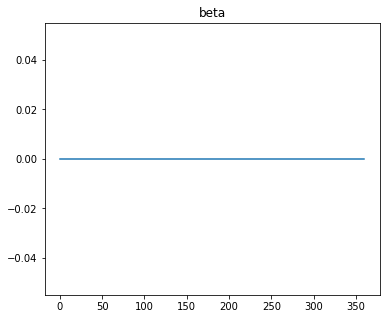

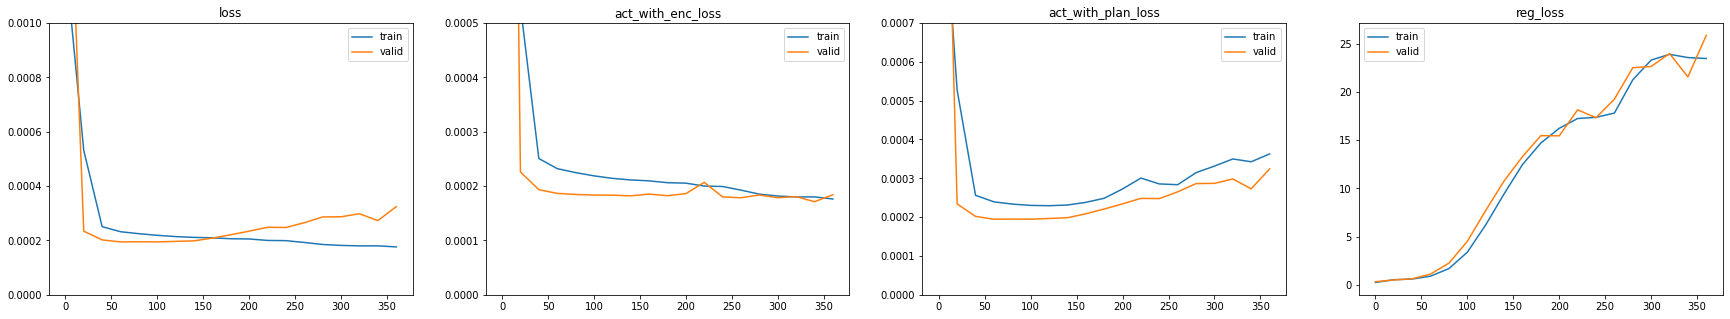

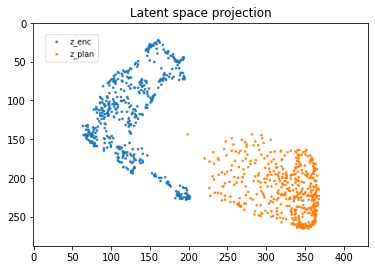

In [172]:
#@title Broke man's Tensorboard
s = np.arange(t, step=valid_inc)

# hparams/
f1,ax1 = plt.subplots(1,1, figsize=(6,5))
ax1.plot(s, beta_result, label='beta')
ax1.set_title('beta')

# losses/
f2,ax2 = plt.subplots(1,4, figsize=(30,5))
ax2[0].plot(s, train_loss_result, label='train')
ax2[0].plot(s, valid_loss_result, label='valid')
ax2[0].set_title('loss')
ax2[0].set_ylim(0,1e-3)
ax2[1].plot(s, train_act_with_enc_loss_result, label='train')
ax2[1].plot(s, valid_act_with_enc_loss_result, label='valid')
ax2[1].set_title('act_with_enc_loss')
ax2[1].set_ylim(0,5e-4)
ax2[2].plot(s, train_act_with_plan_loss_result, label='train')
ax2[2].plot(s, valid_act_with_plan_loss_result, label='valid')
ax2[2].set_title('act_with_plan_loss')
ax2[2].set_ylim(0,7e-4)
ax2[3].plot(s, train_reg_loss_result, label='train')
ax2[3].plot(s, valid_reg_loss_result, label='valid')
ax2[3].set_title('reg_loss')
[ax.legend() for ax in ax2]
# [ax.set_yscale('log') for ax in ax2]

# images/
f3,ax3 = plt.subplots(1,1, figsize=(6,5))
ax3.imshow(latent_img_result[-1].numpy()[0], label='latent_img_result')
ax3.set_title('Latent space projection')

plt.show()

In [173]:
#%tensorboard --logdir {tb_base_dir}

In [174]:
#@title Sample a batch for timeseries plotting
# Lets plot pred actions vs true actions
v_it = iter(valid_dataset.repeat())
batch = v_it.next()
states,acts,goals, seq_lens = batch['obs'], batch['acts'], batch['goals'], batch['seq_lens']
encoding = encoder(states,acts)
plan, _ = planner((states[:, 0, :], goals[:, 0, :])) # TODO this is really aggravating, if we have variable sequence lengths we need to pass
                                                      # Through the indices of the final index, can't just use the last 1, unless we copy it out instead of tiling?
# check if encoder is overfitting on validation
z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, WINDOW_SIZE, 1))
enc_act_distrib = model((states, z_enc, goals))

# true validation performance, w/ planner
z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, WINDOW_SIZE, 1))
pred_acts = model((states, z, goals)) # TODO Check can you backprop through samples

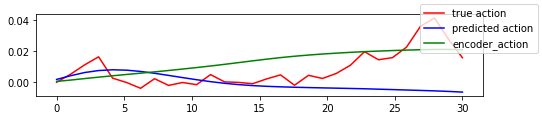

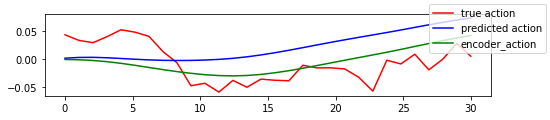

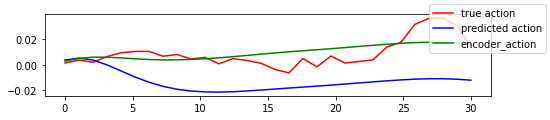

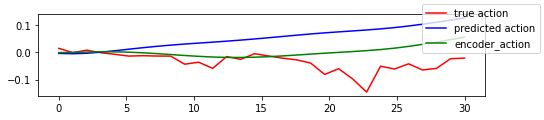

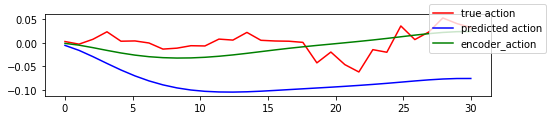

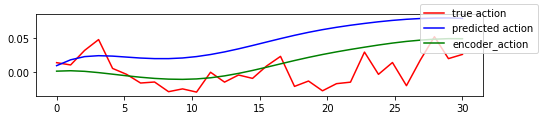

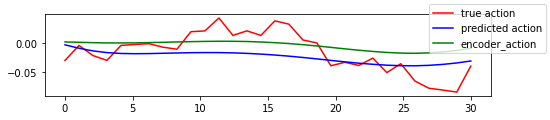

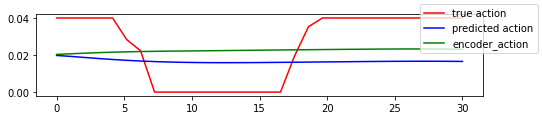

In [176]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
idx = 4
length = int(seq_lens[idx])
actions_space = acts.shape[2]
x = np.linspace(0, length, num=length) 
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(8,1.5), squeeze=False)
    # One ModelW
    true = axes[0,0].plot(x,acts[idx,:length,i],'r')
    predicted = axes[0,0].plot(x,pred_acts[idx, :length,i], 'b')
    enc_predicted = axes[0,0].plot(x,enc_act_distrib[idx, :length,i], 'g')
    
    fig.legend( ('true action', 'predicted action', 'encoder_action'))    
    plt.show()

In [ ]:
def save_weights():
    model_name = 'b1e-3_cyclic_newdata'
    path = '/content/drive/My Drive/Robotic Learning/LMP_test/'+model_name
    try:
      os.makedirs(path)
    except:
      pass

    model.save_weights(path + 'model.h5')
    planner.save_weights(path + 'planner.h5')
    encoder.save_weights(path + 'encoder.h5')

save_weights()

In [ ]:
#@title Explore MMD INFOVAE reg for encoder, with planner chasing it.



In [ ]:
def compute_kernel(x, y):
  x_size = tf.shape(x)[0]
  y_size = tf.shape(y)[0]
  dim = tf.shape(x)[1]
  tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
  print(tiled_x, x, y)
  tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
  print(tiled_x.shape, tiled_y.shape)
  return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=2.0/LATENT_DIM):
  x_kernel = compute_kernel(x, x)
  y_kernel = compute_kernel(y, y)
  xy_kernel = compute_kernel(x, y)
  return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

true_samples = tfd.Normal([0.1,0.1,0.1], [1,1,1])
encoding = tfd.Normal([0.1,0.1,0.1], [1,1,1])
loss_mmd = compute_mmd(true_samples.sample(), encoding.sample())


InvalidArgumentError: ignored

In [ ]:


LAYER_SIZE = 512
LATENT_DIM = 256

with strategy.scope():
    # Keras .fit API
  #loss_fn = lambda y, p_y: -p_y.log_prob(y)
  action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

  def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

  def compute_mmd(x, y, sigma_sqr=2.0/LATENT_DIM):
      x_kernel = compute_kernel(x, x)
      y_kernel = compute_kernel(y, y)
      xy_kernel = compute_kernel(x, y)
      return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
  
  def compute_loss(labels, predictions, mask, seq_lens):
      per_example_loss = action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_regularisation_loss(plan, encoding):
      reg_loss = KL(plan, encoding) #+ KL(encoding, plan)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def encoder_regularisation(encoding):
    B = encoding.shape[0]
    true_samples = tf.random_normal(tf.stack([B, z_dim]))
    loss_mmd = compute_mmd(true_samples, encoding.sample())

  train_act_loss = tf.keras.metrics.Mean(name='act_loss')
  valid_act_loss = tf.keras.metrics.Mean(name='valid_act_loss')

  train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
  valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')

  valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
  train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')

  
  model_params = {'layer_size':LAYER_SIZE, 'GCBC':False}
  model = actor(**model_params)

  model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
  encoder = ENCODER_LSTM(latent_dim=LATENT_DIM)
  planner = create_planner(**model_params)

  optimizer = tfa.optimizers.AdamW(1e-4, 2e-4) #tf.keras.optimizers.Adam(2e-4)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

def step(inputs, GCBC=False, training = False):
  (states, goals, actions, mask, seq_lens) = inputs
  if GCBC:
    distrib = model(states, goals=goals, training = training)
    return  compute_loss(actions, distrib, mask, seq_lens), distrib
  else:
  
    encoding = encoder(states, actions, training=training)
    final_goals = goals[:, 0, :]
    plan, _ = planner((states[:, 0, :], final_goals))  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
    if training: # we must expand it out so each input state has a corresponding plan
      z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training=training)
      z_plan = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      plan_acts = model(states, z_plan, goals, training=training)
      train_act_with_plan_loss.update_state(compute_loss(actions, plan_acts, mask, seq_lens))
    
    else:
      # check if encoder is overfitting on validation
      z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      enc_act_distrib = model(states, z_enc, goals, training = training)
      valid_act_with_enc_loss.update_state(compute_loss(actions, enc_act_distrib, mask, seq_lens))

      # true validation performance, w/ planner
      z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training = training) 
      

    action_loss = compute_loss(actions, distrib, mask, seq_lens)
    
    regularisation_loss = compute_regularisation_loss(plan, encoding)
    
    return action_loss, regularisation_loss


# Now outside strategy .scope
def train_step(inputs, GCBC = False):
  with tf.GradientTape() as tape:
    act_loss, reg_loss = step(inputs, GCBC = GCBC, training=True)
    loss = act_loss + reg_loss  * BETA
    
  train_act_loss.update_state(act_loss)
  train_reg_loss.update_state(reg_loss)
  gradients = tape.gradient(loss, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables))
  
  return loss

def test_step(inputs, GCBC=False):
  act_loss, reg_loss = step(inputs, GCBC = GCBC, training=False)
  valid_act_loss.update_state(act_loss)
  valid_reg_loss.update_state(reg_loss)
  return act_loss + reg_loss  * BETA

@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)

@tf.function
def distributed_test_step(dataset_inputs):
  per_replica_losses = strategy.run(test_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)


train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset.repeat()))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset.repeat()))

In [ ]:


trial_run(1e-2)
trial_run(1e-3)
trial_run(1e-4)
trial_run(1e-1)

In [ ]:
int(seq_lens[idx])

30

Gradients are "calculated on each replica, they are synced across the replicas by **summing** them"
https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function

In [ ]:
# Keras .fit API
loss_fn = lambda y, p_y: -p_y.log_prob(y)
# loss_fn = MeanSquaredError()

def compute_loss(labels, predictions):
    per_example_loss = loss_fn(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

with strategy.scope():
    model = create_lstm_model_v2(**model_params)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                experimental_steps_per_execution = 2,
                loss=compute_loss,
                metrics=['mean_absolute_error'])

steps_per_epoch = 100
validation_steps = 10

callbacks = [
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    # tf.keras.callbacks.LearningRateScheduler(decay),
]

history = model.fit(train_data,
          epochs=10,
          steps_per_epoch=steps_per_epoch,
          validation_data=valid_data, 
          validation_steps=validation_steps
        #   callbacks=callbacks
          )

Epoch 1/10
 10/100 [==>...........................] - ETA: 3:02 - loss: 979.5474 - mean_absolute_error: 1.1801 

KeyboardInterrupt: ignored

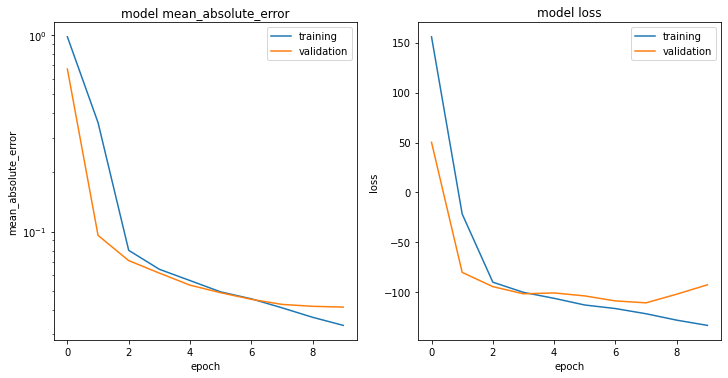

In [ ]:
def display_training_curves(training, validation, title, subplot, yscale='linear'):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])
  plt.yscale(yscale)

plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history.history['mean_absolute_error'], history.history['val_mean_absolute_error'], 'mean_absolute_error', 121, yscale='log')
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 122)

In [ ]:
# For doing custom TPU training loops

# @tf.function
# def train_step(iterator):
#   """The step function for one training step"""

#   def step_fn(inputs):
#     """The computation to run on each TPU device."""
#     images, labels = inputs
#     with tf.GradientTape() as tape:
#       logits = model(images, training=True)
#       loss = tf.keras.losses.sparse_categorical_crossentropy(
#           labels, logits, from_logits=True)
#       loss = tf.nn.compute_average_loss(loss, global_batch_size=batch_size)
#     grads = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
#     training_loss.update_state(loss * strategy.num_replicas_in_sync)
#     # training_accuracy.update_state(labels, logits)

#   strategy.run(step_fn, args=(next(iterator),))

# Eval

In [ ]:
import time
import pandaRL
import gym
import matplotlib.pyplot as plt 
from IPython.display import display, clear_output
import imageio
import eval

if RELATIVE_JOINTS:
  env = gym.make('pandaPlayJoints1Obj-v0')
else:
  env =  gym.make('pandaPlay-v0')
env.reset()
env.render('playback')

current_dir=/content/local_packages/pandaRL/pandaRL/envs
/content/local_packages/pandaRL/pandaRL/envs


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# model.save_weights('/content/drive/My Drive/Robotic Learning/inference_model.h5')

In [ ]:
inference_model = create_lstm_model_v2(**model_params, training=False)
inference_model.set_weights(model.get_weights())
# inference_model.load_weights('/content/drive/My Drive/Robotic Learning/inference_model.h5')

In [ ]:
f = 14 # 51
eval_data = np.load(PYBULLET_DATA_DIR+'/obs_act_etc/'+str(f)+'/data.npz')
potential_start_points = glob.glob(PYBULLET_DATA_DIR+'/states_and_ims/'+str(f)+'/env_states/*.bullet')

observations = eval_data['obs']
achieved_goals = eval_data['achieved_goals']
if RELATIVE_JOINTS:
  joints = eval_data['target_poses'] - eval_data['joint_poses'][:,:7]
  gripper = np.expand_dims(eval_data['acts'][:, -1], -1)
  actions = np.concatenate([joints,gripper], -1) 
else:
  actions = eval_data['acts']

def get_random_start_point(potential_start_points):
    idx = np.random.choice(len(potential_start_points))
    path = potential_start_points[idx]
    tstep = int(path.split("/")[-1].replace('.bullet',''))
    return path, tstep

## Inference Loop

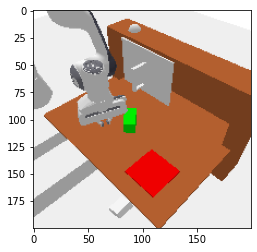

In [ ]:
# Play out action histories
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

vid_path = 'output/videos/trajectory.mp4'
with imageio.get_writer(vid_path, mode='I') as writer:
    for i in range(start, start+60):
        o ,r, d, _ = env.step(actions[i,:])
        writer.append_data(o['img'])
        clear_output(wait=True)
        fig = plt.imshow(o['img'])
        plt.show()
        time.sleep(0.01)

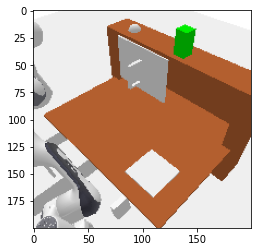

In [ ]:
# Play out stateful model predictions
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

vid_path = 'output/videos/trajectory.mp4'

eval_seq_len = 60
obs_in = observations[start][tf.newaxis,tf.newaxis,:]
g_in = achieved_goals[start+eval_seq_len][tf.newaxis,tf.newaxis,:] # same as two expand_dims
inference_model.reset_states()

eval_obs = []
eval_acts = []

with imageio.get_writer(vid_path, mode='I') as writer:
    for i in range(start, start+eval_seq_len):
        a = inference_model([obs_in, g_in]).sample()[0,0,:] # Reduce to 1d
        o ,r, d, _ = env.step(a)
        obs_in = o['observation'][tf.newaxis,tf.newaxis,:]
        writer.append_data(o['img'])
        clear_output(wait=True)
        fig = plt.imshow(o['img'])
        plt.show()

        eval_obs.append(o['observation'])
        eval_acts.append(a)
    inference_model.reset_states()

eval_obs = np.vstack(eval_obs)
eval_acts = np.vstack(eval_acts)

In [ ]:
eval.render_mp4(vid_path)

## Plotting Timeseries of obs, acts

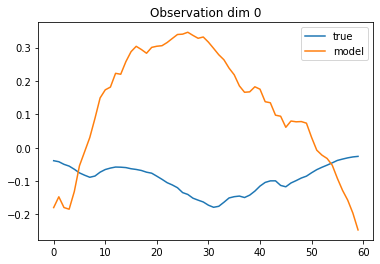

In [ ]:
#@title Visualise observations
obs_idx = 0 #@param {type:"slider", min:0, max:25, step:1}

plt.figure()
t = range(eval_seq_len)
plt.plot(t, observations[start:start+eval_seq_len,obs_idx], label='true')
plt.plot(t, eval_obs[:,obs_idx], label='model')
plt.title(f'Observation dim {obs_idx}')
plt.legend()
plt.show()

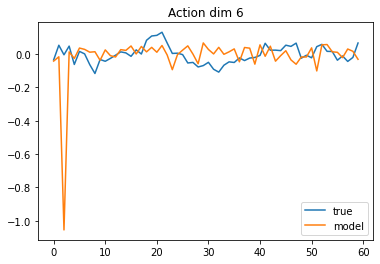

In [ ]:
#@title Visualise actions
acts_idx = 6 #@param {type:"slider", min:0, max:7, step:1}

plt.figure()
t = range(eval_seq_len)
plt.plot(t, actions[start:start+eval_seq_len,acts_idx], label='true')
plt.plot(t, eval_acts[:,acts_idx], label='model')
plt.title(f'Action dim {acts_idx}')
plt.legend()
plt.show()

# Perfect, Deterministic Reset and Replay

In [ ]:
import gym
import time
import pandaRL
if RELATIVE_JOINTS:
    env = gym.make('pandaPlayJoints-v0')
else:
    env = gym.make('pandaPlay-v0')
env.render('human')
env.reset()

In [ ]:
idx = np.random.choice(len(o))
traj_end = len(np.where(m[idx] == 1)[0])-1
#env.panda.reset_goal_pos(ag_to_dg(g[idx, traj_end,:]))
env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')



In [ ]:
for i in range(0, traj_end+1):
    #env.p.restoreState(fileName=dataset_path+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,i]))+'.bullet')
    #time.sleep(0.1)
    env.step(a[idx, i, :])

In [ ]:
def test_subsequences(use_ori = True, replay=False):
    
    t_it = iter(tf_valid_data)
    obs, acts, goals, masks, pth, tsteps = t_it.next()
    idx = np.random.choice(len(obs))
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    
    env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    
    o = tf.expand_dims(obs[idx][0],0)
    
    goal = goals[idx, traj_end,:]
    #env.panda.reset_goal_pos(ag_to_dg(goal))
    goal = tf.expand_dims(goal, 0)
    
    
    if replay:
        retries = 1
    else:
        retries = 1
        
    for i in range(0,retries):
        past_state = [None, None]
        for i in range(0, traj_end+1):

            distrib, past_state = model(o, goal,  past_state = past_state)
            a = distrib.sample().numpy().squeeze() 
            
            if use_ori:
                a[3:7] =  np.array(env.panda.default_arm_orn) # because it hasn't ever had to cope with
            if replay:
                a=acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(o['observation'], 0)

# MLP Evaluation

In [ ]:
def ag_to_dg(ag):
    dg = np.concatenate([ag[0:3], ag[7:10]])
    return dg

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:
valid = dataset[int(N_TRAJS*train_partition):]

def test_subsequences():
    
    obs, acts, goals, masks = sample_sequence_batch(valid)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = np.expand_dims(obs[idx][traj_end][START_GOAL:END_GOAL],0)
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()
    past_state = [None, None]
    
    for i in range(0,3):
        for i in range(0, traj_end+1):
            o = tf.expand_dims(o[START_OBS:END_OBS], 0)
            distrib, past_state = model(o, goal,  past_state = past_state)

            a = distrib.sample().numpy().squeeze() 
            #a = acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            env.render()


In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_goals, traj_init_o, traj_init_v = [valid[idx][key] for key in valid[idx].keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = tf.cast(tf.expand_dims(traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL], 0), tf.float32)
        o = tf.cast(tf.expand_dims(o[START_OBS:END_OBS],0), tf.float32)
        distrib, past_state = model(o,goal, past_state = past_state)
        
        #a = distrib.sample().numpy().squeeze() 
        a = traj_acts[t, :] # uncomment this to replay play subsequences
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)]) 

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])  

88.02201747894287 19.151499032974243


In [ ]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim
registering the liscence


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# MLP Evaluation

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:

def test_subsequences():
    obs, acts, masks = sample_sequence_batch(valid_data)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = obs[idx][traj_end][START_GOAL:END_GOAL]
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()


    past_state = [None, None]

    for i in range(0, traj_end+1):
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()
    

In [ ]:
for i in range(0,100):
    test_subsequences()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])  